In [1]:
#Set up environment and import necessary dependencies

%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple;
import numpy as np;

#Import some general util stuff
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

#Make sure the directory is set to import the lab's version of keras
scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)

import deeplift.conversion.keras_conversion as kc
import theano

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, cuDNN not available)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
#Load the keras model, make sure you normalise the weights
#of the first convolutional layer to be mean-centered at each position.
model_weights = "record_2_model_9OmQ2_modelWeights.h5"
model_yaml = "record_2_model_9OmQ2_modelYaml.yaml"
reload(kc)
from keras.models import model_from_yaml                                    
keras_model = model_from_yaml(open(model_yaml).read())                                  
keras_model.load_weights(model_weights)

Using Theano backend.


In [3]:
keras_model.layers

In [4]:
keras_model.layers[3].get_weights()[0].shape

(100, 2)

In [5]:
keras_model.layers[2].get_config()

{'activation': 'tanh',
 'cache_enabled': True,
 'custom_name': 'gru',
 'go_backwards': False,
 'init': 'glorot_uniform',
 'inner_activation': 'hard_sigmoid',
 'inner_init': 'orthogonal',
 'input_dim': 4,
 'input_length': None,
 'input_shape': (None, 4),
 'name': 'GRU',
 'output_dim': 100,
 'return_sequences': False,
 'stateful': False,
 'trainable': True}

In [6]:
#compile a function to get the outputs
keras_output_func = theano.function([keras_model.layers[0].input],
                               keras_model.layers[-1].get_output(), allow_input_downcast=True)

In [7]:
from importDataPackage import importData
reload(importData)
trainData, validData, testData = importData.loadTrainTestValidFromYaml("yaml/features.yaml","yaml/labels.yaml", "yaml/splits.yaml")

(0, 'rows skipped from', 'singleMotifSim_motif-CTCF_known1_seqLength-150_numSeqs-1000.simdata.gz')
(0, 'rows skipped from', 'singleMotifSim_seqLength-150_numSeqs-1000.simdata.gz')
Returning desired dict
Making numpy arrays out of the loaded files
('train', 'shapeX', (1400, 1, 4, 150))
('train', 'shapeY', (1400, 2))
('valid', 'shapeX', (300, 1, 4, 150))
('valid', 'shapeY', (300, 2))
('test', 'shapeX', (300, 1, 4, 150))
('test', 'shapeY', (300, 2))


In [8]:
#get predictions from keras model
keras_test_preds = keras_output_func(testData.X)

In [9]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=testData.Y[:,0], y_score=keras_test_preds[:,0])

0.97960000000000003

In [26]:
import deeplift
reload(deeplift)
reload(kc)
reload(deeplift.blobs)
reload(deeplift.backend)
#(haven't implemented reshape and permute yet but I want to get right to it)
deeplift_layers = [deeplift.blobs.Input_FixedDefault(default=0.25, num_dims=3, shape=(150,4), name="input")]+\
    kc.gru_conversion(keras_model.layers[2], name=str("layer0"))+\
    kc.dense_conversion(keras_model.layers[3], name=str("layer1"), mxts_mode=deeplift.blobs.MxtsMode.DeepLIFT, expo_upweight_factor=0)+\
    kc.activation_conversion(keras_model.layers[4], name=str("layer2"), mxts_mode=deeplift.blobs.MxtsMode.DeepLIFT, expo_upweight_factor=0)

deeplift.util.connect_list_of_layers(deeplift_layers)
deeplift_layers[-1]._build_fwd_pass_vars()
deeplift_model = deeplift.models.SequentialModel(layers=deeplift_layers)

In [27]:
deeplift_output_func = theano.function([deeplift_model.get_layers()[0].get_activation_vars()],
                                        deeplift_model.get_layers()[-1].get_activation_vars(),
                                        allow_input_downcast=True)

In [28]:
deeplift_test_preds = deeplift_output_func(np.transpose(np.squeeze(testData.X), axes=(0,2,1)))

In [29]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true=testData.Y[:,0], y_score=deeplift_test_preds[:,0])

0.97960000000000003

In [31]:
deeplift_model._set_scoring_mode_for_pre_activation_target_layer(deeplift_model.get_layers()[-2])
deeplift_model.get_layers()[-2].set_active()
deeplift_model.get_layers()[-2].update_task_index(0)
deeplift_model.get_layers()[0].update_mxts()

In [32]:
hidden_vars_multipliers_func = theano.function([deeplift_model.get_layers()[0].get_activation_vars()],
                                               deeplift_model.get_layers()[1].multipliers_on_hidden_states,
                                               allow_input_downcast=True)

In [33]:
hidden_vars_multipliers = hidden_vars_multipliers_func(np.transpose(np.squeeze(testData.X), axes=(0,2,1)))

In [37]:
np.max(hidden_vars_multipliers)

6.6899759e+26

In [47]:
contribs_func = deeplift_model.get_target_contribs_func(find_scores_layer_idx=0)
imp_scores = contribs_func(task_idx=0,
                           input_data_list=[np.transpose(np.squeeze(testData.X), axes=(0,2,1))],
                           batch_size=10, progress_update=None)

In [50]:
print(np.max(imp_scores), np.min(imp_scores))

1.68016e+26 -1.85878e+26


In [51]:
np.array(imp_scores).shape

(300, 150, 4)

In [52]:
top_predicted_positives = [x[0] for x in sorted(enumerate(testData.Y[:,0]), key=lambda x: -x[1])]

In [53]:
scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to the enhancer_prediction_code repo");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT");
from deepLIFTutils import makePngOfSequenceDeepLIFTScores

('Saving', 'blah.png')


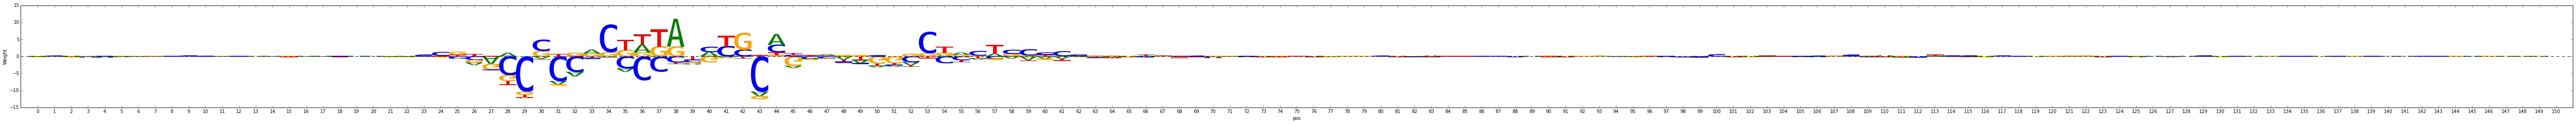

In [54]:
makePngOfSequenceDeepLIFTScores(imp_scores[top_predicted_positives[0]].T[None,:,:]
                                    , pngName="blah.png")